In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d amitabhajoy/bengaluru-house-price-data

  0% 0.00/195k [00:00<?, ?B/s]
100% 195k/195k [00:00<00:00, 84.8MB/s]


In [2]:
!unzip bengaluru-house-price-data.zip

Archive:  bengaluru-house-price-data.zip
  inflating: Bengaluru_House_Data.csv  


In [84]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv('/content/Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
df.shape

(13320, 9)

#**Data Cleaning**

In [7]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [14]:
df.dtypes

area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

In [8]:
new_df = df.drop(['area_type','society', 'balcony','availability'],axis=1)
new_df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [9]:
new_df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [10]:
new_df = new_df.dropna()

In [11]:
new_df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [12]:
new_df['bhk'] = new_df['size'].apply(lambda x: int(x.split(' ')[0]))

In [13]:
new_df.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [15]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

In [18]:
new_df[~new_df['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [19]:
def convert_sqrt_to_num(x):
  tokens = x.split('-')
  if len(tokens) == 2:
    return (float(tokens[0])+ float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None

In [20]:
new_df2 = new_df.copy()
new_df2['total_sqft'] = new_df2['total_sqft'].apply(convert_sqrt_to_num)

In [22]:
new_df2.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

#**Feature Engineering**

In [24]:
cleaned_df = new_df2.copy()
cleaned_df['price_per_sqft'] = cleaned_df['price']*100000/cleaned_df['total_sqft']
cleaned_df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [26]:
cleaned_df.location.nunique()

1304

In [28]:
cleaned_df.location = cleaned_df.location.apply(lambda x: x.strip())
location_stats = cleaned_df.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [29]:
location_stats_less_10 = location_stats[location_stats<=10]
location_stats_less_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [32]:
cleaned_df.location = cleaned_df.location.apply(lambda x: 'other' if x in location_stats_less_10 else x)

#**Outlier Removal**

In [34]:
cleaned_df[cleaned_df.total_sqft/cleaned_df.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [35]:
cleaned_df.shape

(13246, 7)

In [36]:
cleaned_df_out = cleaned_df[~(cleaned_df.total_sqft/cleaned_df.bhk<300)]
cleaned_df_out.shape

(12502, 7)

In [37]:
cleaned_df_out.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [38]:
def remove_pps_outlier(df):
  df_out = pd.DataFrame()
  for key, subdf in df.groupby('location'):
    m = np.mean(subdf.price_per_sqft)
    st = np.std(subdf.price_per_sqft)
    reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
    df_out = pd.concat([df_out,reduced_df], ignore_index=True)
  return df_out



In [39]:
df_out = remove_pps_outlier(cleaned_df_out)
df_out.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


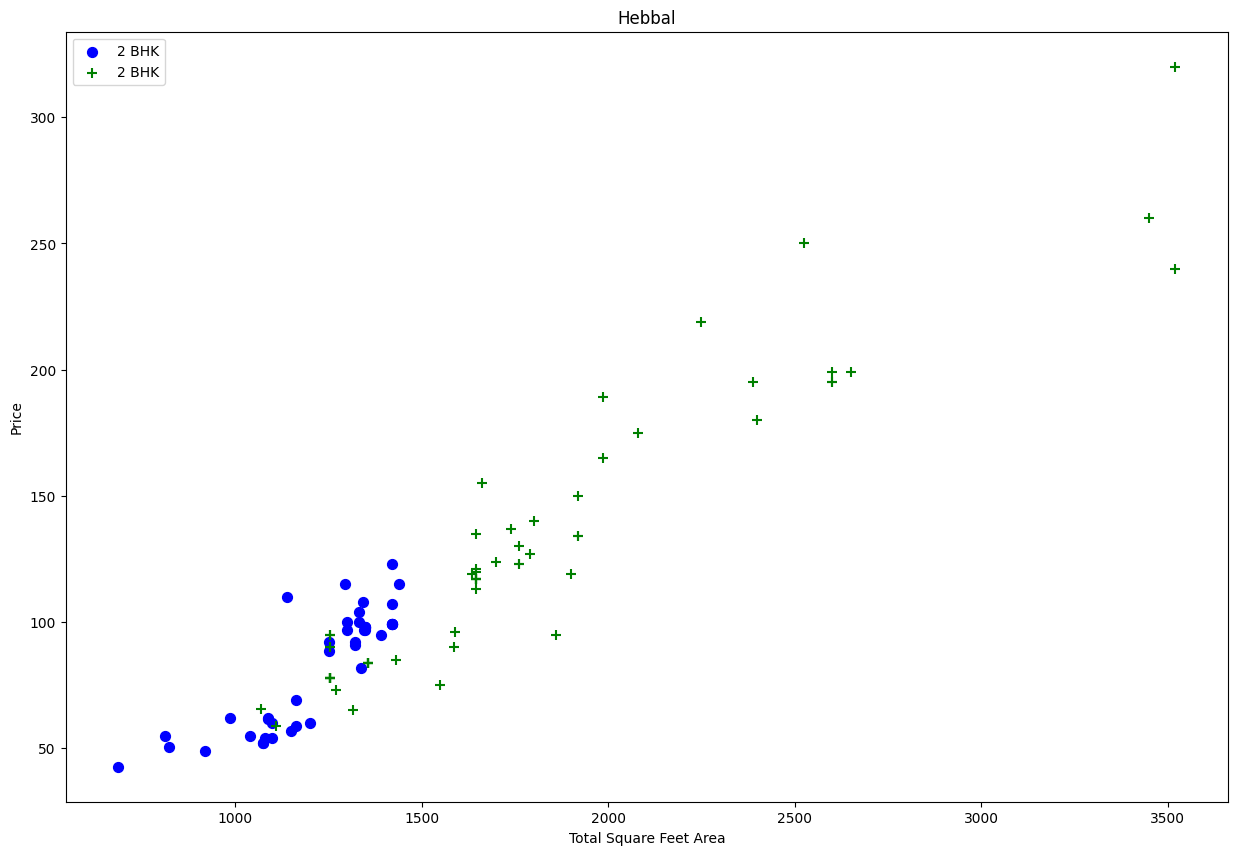

In [47]:
def plot_scatter_chart(df,location):
  bhk2 = df[(df.location==location) & (df.bhk==2)]
  bhk3 = df[(df.location==location) & (df.bhk==3)]
  matplotlib.rcParams['figure.figsize'] = (15,10)
  plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK',s=50)
  plt.scatter(bhk3.total_sqft,bhk3.price, marker='+',color='green',label='2 BHK',s=50)
  plt.xlabel('Total Square Feet Area')
  plt.ylabel('Price')
  plt.title(location)
  plt.legend()

plot_scatter_chart(df_out,'Hebbal')

In [57]:
def remove_bhk_outlier(df):
  exclude_indices = np.array([])
  for location, location_df in df.groupby('location'):
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby('bhk'):
      bhk_stats[bhk] = {
          'mean' : np.mean(bhk_df.price_per_sqft),
          'std'  : np.std(bhk_df.price_per_sqft),
          'count': bhk_df.shape[0]
      }
    for bhk, bhk_df in location_df.groupby('bhk'):
      stats = bhk_stats.get(bhk-1)
      if stats and stats['count']>5:
        exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
  return df.drop(exclude_indices,axis=0)

df_out2 = remove_bhk_outlier(df_out)
df_out2.shape

(7329, 7)

Text(0, 0.5, 'Count')

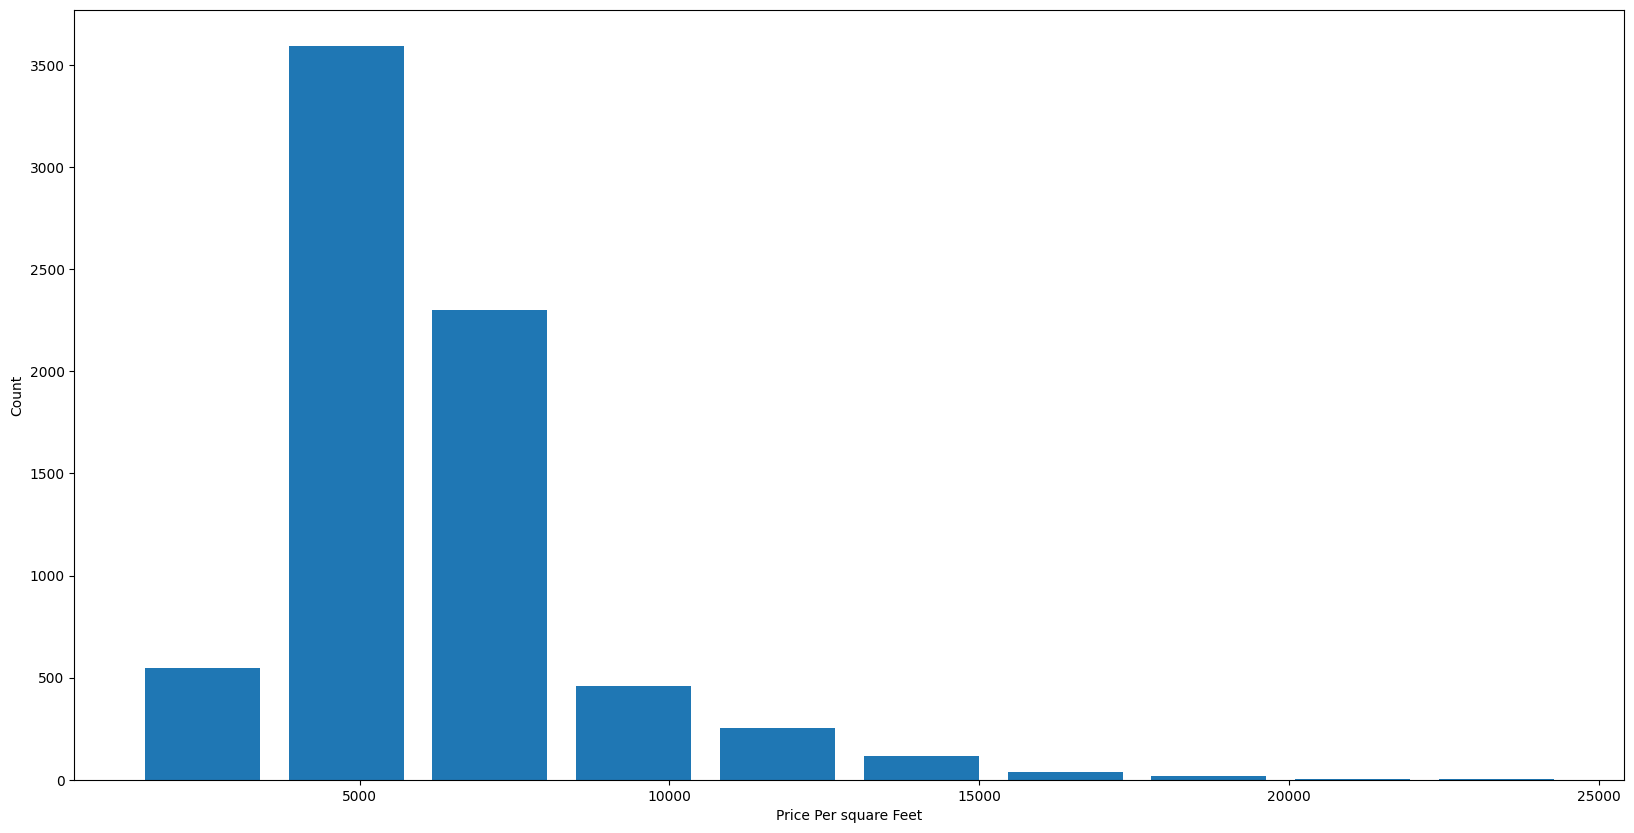

In [58]:
matplotlib.rcParams['figure.figsize'] = (20,10)
plt.hist(df_out2.price_per_sqft,rwidth=0.8)
plt.xlabel('Price Per square Feet')
plt.ylabel('Count')

In [59]:
df_out2[df_out2.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

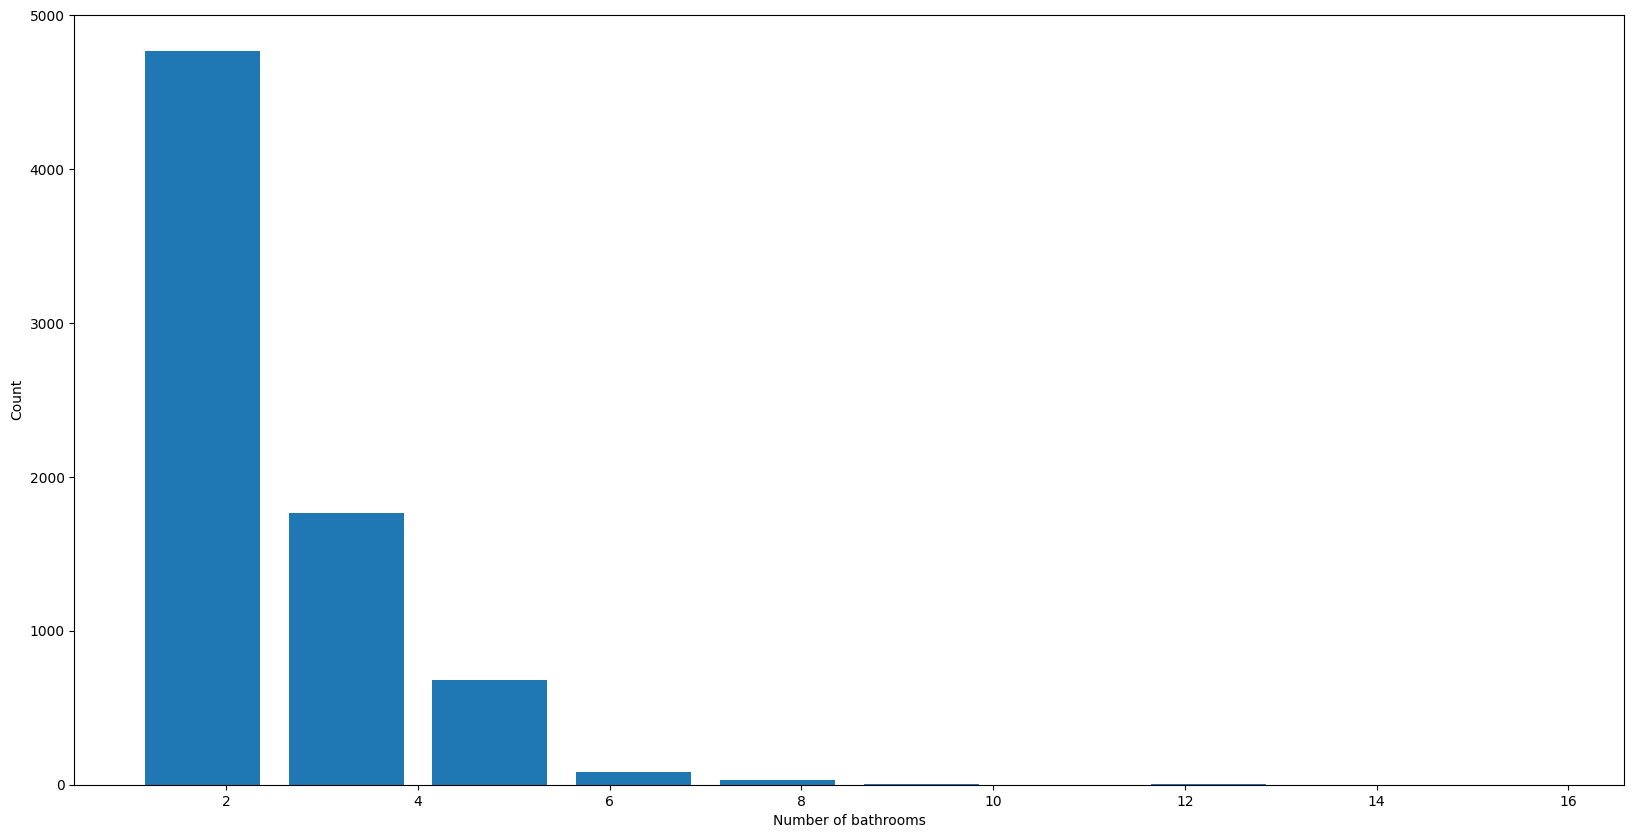

In [60]:
plt.hist(df_out2.bath,rwidth=0.8)
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')

In [76]:
df_out3 = df_out2[df_out2.bath<df_out2.bhk+2]
df_out3.shape

(7251, 7)

#**Encoding**

In [77]:
dummies = pd.get_dummies(df_out3.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
end_df = pd.concat([df_out3,dummies.drop('other',axis=1)],axis=1)
end_df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
end_df2 = end_df.drop(['size','location'],axis=1)

#**Model Building**

In [80]:
X = end_df2.drop('price',axis=1)
y = end_df2['price']
print(X.shape, y.shape)

(7251, 245) (7251,)


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=42)

In [102]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

0.9085417202381809

In [104]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.90854172, 0.91932939, 0.94616996])

In [105]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb.score(X_test,y_test)

0.9733160320936433

In [107]:
y_pred = xgb.predict(X_test)

In [108]:
y_pred

array([79.71401 , 96.32358 , 36.7014  , ..., 80.78525 , 49.76014 ,
       47.843983], dtype=float32)

In [106]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.9106251022049494

In [110]:
def predict_price(location, sqft, bath, bhk):
  loc_index = np.where(X.columns==location)[0][0]

  x = np.zeros(len(X.columns))
  x[0] = sqft
  x[1] = bath
  x[2] = bhk
  if loc_index >=0:
    x[loc_index] = 1

  return xgb.predict([x])[0]

In [118]:
predict_price('1st Block Jayanagar', 2850,4,4)

73.39955

In [119]:
import pickle
with open('model.pickle','wb') as f:
  pickle.dump(xgb,f)